In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Spark EDA/ETL Pipeline

Spark is a unified processing engine that can analyze big data using SQL, machine learning, graph processing or real time stream analysis:

![Spark Engines](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/book_intro/spark_4engines.png)

We will mostly focus on Spark SQL, DataFrames and Machine Learning

Although Spark supports four languages (Scala, Java, Python, R), tonight we will use Python.
Broadly speaking, there are **2 APIs** for interacting with Spark:
- **DataFrames/SQL/Datasets:** general, higher level API for users of Spark
- **RDD:** a lower level API for spark internals and advanced programming

Local mode is typically used for prototyping and learning Spark:

![Notebook + Micro Cluster](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/book_intro/notebook_microcluster.png)

## Download FireCalls Dataset

Note, you can also access the data directly from sfgov.org via this link: https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3

This dataset contains calls to Fire Department. They record various attributes such as call number, Call Date, Call Time, location, Address etc. 

Each call is assigned an Original and Final Priority (Emergency or Not Emergency). Our task is to **predict the final priority of the call based on attributes.**

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

### Create Spark Session

In [2]:
# PySpark :
from pyspark.sql import SparkSession
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages \
                                    org.postgresql:postgresql:42.1.1,org.apache.hadoop:hadoop-aws:2.7.1,com.datastax.spark:spark-cassandra-connector_2.11:2.3.0 \
                                    --executor-memory 4G \
                                    pyspark-shell'
spark = SparkSession.builder.appName('EDA with Spark')\
                            .master("spark://localhost:7077")\
                            .getOrCreate()

In [3]:
spark

### Load Data Frame

Using the SparkSession, create a DataFrame from the CSV file by inferring the schema:

In [4]:
fireServiceCallsDF2 = spark.read.csv('./data/fire_dept_calls.csv', 
                                    header=True, 
                                    inferSchema=True)

In [5]:
fireServiceCallsDF2.count()

4881698

Notice that the above cell takes time to run since it is inferring the schema, by going throught the whole dataset once.

Inferring the schema works for smaller datasets. But when working on multi-TB+ data, it's better to provide an **explicit pre-defined schema manually**, so there's no inferring cost:

### Load Data Frame with Schema

In [127]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BooleanType

# Note that we are removing all space characters from the col names to prevent errors when writing to Parquet later
fireSchema = StructType([StructField('CallNumber', IntegerType(), True),
                     StructField('UnitID', StringType(), True),
                     StructField('IncidentNumber', IntegerType(), True),
                     StructField('CallType', StringType(), True),                  
                     StructField('CallDate', StringType(), True),       
                     StructField('WatchDate', StringType(), True),       
                     StructField('ReceivedDtTm', StringType(), True),       
                     StructField('EntryDtTm', StringType(), True),       
                     StructField('DispatchDtTm', StringType(), True),       
                     StructField('ResponseDtTm', StringType(), True),       
                     StructField('OnSceneDtTm', StringType(), True),       
                     StructField('TransportDtTm', StringType(), True),                  
                     StructField('HospitalDtTm', StringType(), True),       
                     StructField('CallFinalDisposition', StringType(), True),       
                     StructField('AvailableDtTm', StringType(), True),       
                     StructField('Address', StringType(), True),       
                     StructField('City', StringType(), True),       
                     StructField('ZipcodeofIncident', IntegerType(), True),       
                     StructField('Battalion', StringType(), True),                 
                     StructField('StationArea', StringType(), True),       
                     StructField('Box', StringType(), True),       
                     StructField('OriginalPriority', StringType(), True),       
                     StructField('Priority', StringType(), True),       
                     StructField('FinalPriority', IntegerType(), True),       
                     StructField('ALSUnit', BooleanType(), True),       
                     StructField('CallTypeGroup', StringType(), True),
                     StructField('NumberofAlarms', IntegerType(), True),
                     StructField('UnitType', StringType(), True),
                     StructField('Unitsequenceincalldispatch', IntegerType(), True),
                     StructField('FirePreventionDistrict', StringType(), True),
                     StructField('SupervisorDistrict', StringType(), True),
                     StructField('NeighborhoodDistrict', StringType(), True),
                     StructField('Location', StringType(), True),
                     StructField('RowID', StringType(), True)])

Notice that we specified the schema this time!

In [128]:
fireServiceCallsDF = spark.read.csv('./data/fire_dept_calls.csv',
                                    header=True, schema=fireSchema)

In [8]:
fireServiceCallsDF.count()

4881698

### Show first 5 records

Look at the first 5 records in the DataFrame:

In [9]:
fireServiceCallsDF.limit(5).toPandas()

,CallNumber,UnitID,IncidentNumber,CallType,CallDate,WatchDate,ReceivedDtTm,EntryDtTm,DispatchDtTm,ResponseDtTm,...,ALSUnit,CallTypeGroup,NumberofAlarms,UnitType,Unitsequenceincalldispatch,FirePreventionDistrict,SupervisorDistrict,NeighborhoodDistrict,Location,RowID
0,1030101,E18,306091,Medical Incident,04/12/2000,04/12/2000,04/12/2000 09:00:29 PM,04/12/2000 09:01:40 PM,04/12/2000 09:02:00 PM,None,...,False,None,1,ENGINE,1,8,4,Sunset/Parkside,"(37.7487247711275, -122.495504020186)",001030101-E18
1,1030104,M14,30612,Medical Incident,04/12/2000,04/12/2000,04/12/2000 09:09:02 PM,04/12/2000 09:10:17 PM,04/12/2000 09:10:29 PM,04/12/2000 09:12:11 PM,...,True,None,1,MEDIC,2,8,4,Sunset/Parkside,"(37.7540326780595, -122.502185504543)",001030104-M14
2,1030106,M36,30614,Medical Incident,04/12/2000,04/12/2000,04/12/2000 09:09:44 PM,04/12/2000 09:10:56 PM,04/12/2000 09:11:47 PM,None,...,False,None,1,MEDIC,1,2,6,Tenderloin,"(37.7764405100838, -122.418481123408)",001030106-M36
3,1030107,E01,30615,Alarms,04/12/2000,04/12/2000,04/12/2000 09:13:47 PM,04/12/2000 09:13:51 PM,04/12/2000 09:14:13 PM,04/12/2000 09:15:58 PM,...,False,None,1,ENGINE,3,3,6,Tenderloin,"(37.7825474000421, -122.412247935495)",001030107-E01
4,1030108,RS1,30616,Medical Incident,04/12/2000,04/12/2000,04/12/2000 09:14:43 PM,04/12/2000 09:16:11 PM,04/12/2000 09:16:24 PM,04/12/2000 09:18:20 PM,...,False,None,1,RESCUE SQUAD,2,1,3,Financial District/South Beach,"(37.7863072236365, -122.405294845215)",001030108-RS1


### Column Names and Data Types

Print just the column names in the DataFrame:

In [10]:
fireServiceCallsDF.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- ReceivedDtTm: string (nullable = true)
 |-- EntryDtTm: string (nullable = true)
 |-- DispatchDtTm: string (nullable = true)
 |-- ResponseDtTm: string (nullable = true)
 |-- OnSceneDtTm: string (nullable = true)
 |-- TransportDtTm: string (nullable = true)
 |-- HospitalDtTm: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- ZipcodeofIncident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPr

### Number of columns

In [11]:
len(fireServiceCallsDF.columns)

34

### Number of Rows

Count how many rows total there are in DataFrame (and comparre how long it takes to do a full scan from S3):

In [12]:
fireServiceCallsDF.count()

4881698

There are 4.8 million rows in the DataFrame and it takes some seconds to do a full read of it.

### Missing Value Count

In [13]:
from pyspark.sql.functions import col,sum
def missing_stats2(df):
    num_rows = df.count()
    missing = df.select(*((sum(col(c).isNull().cast("int"))).alias(c)  for c in df.columns))
    
    
    # use pandas to convert it to percent and recast it to spark dataframe
    missing = missing.toPandas().T
    missing = missing.reset_index()
    missing.columns = ["column","missing"]
    missing["pct_missing"]  = missing["missing"] * 100 / num_rows
    missing = missing.sort_values('pct_missing', ascending=False)
    
    ## convert back to spark data frame
    missing = spark.createDataFrame(missing)
    
    return missing

In [14]:
missing_stats2(fireServiceCallsDF).toPandas()

,column,missing,pct_missing
0,HospitalDtTm,3734652,76.503135
1,TransportDtTm,3600973,73.764764
2,CallTypeGroup,2804597,57.451260
3,OnSceneDtTm,1118378,22.909611
4,ResponseDtTm,407699,8.351582
5,AvailableDtTm,76884,1.574944
6,OriginalPriority,25529,0.522953
7,ZipcodeofIncident,14062,0.288056
8,City,7384,0.151259
9,StationArea,2325,0.047627


In [15]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

In [16]:
# ## put more descriptions of how this was achieved-
# ## spend time to understand how decorators work - Object Oriented Python , TDD
# @interact
# def show_articles_more_than(column=sorted(list(fireServiceCallsDF.columns))):
#     return fireServiceCallsDF.select(column).limit(15).toPandas()

## ![Spark Logo Tiny](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/general/logo_spark_tiny.png) **Analysis with PySpark DataFrames API**

<font color='red'>
    
* Dataframes are immutable
    
* Every transformation returns a new dataframe

* Actions executes all transformations

</font>

We will only use the following variables for our anlysis:

* **ALS Unit** : Indicates if the unit had Advanced Life Support or not
* **Battalion** : Emergency Response District (There are 9 Fire Emergency Response Districts)
* **Call Type** : Reason for call
* **City** : City of Incident
* **Neighborhood District** : Neighborhood District associated with this address
* **Station Area** : Fire Station First Response Area associated with the address of the incident
* **Unit Type** : Type of Unit
* **Fire Prevention District** : Bureau of Fire Prevention District associated with this address
* **Number of Alarms** : Number of alarms associated with the incident. This is a number between 1 and 5
* **Supervisor District** : Supervisor District associated with this address (note: these are the districts created in 2012)
* **ReceivedDtTm** : Date and time of call is received at the 911 Dispatch Center.
* **Location** : latitude and longitude of incident
* **FinalPriority** : Final Reason (2 or 3)

### Common Operations

### Drop columns
* Lots of missing values
* Not needed

In [17]:
fireServiceCallsDF = fireServiceCallsDF.drop('Address',
    'AvailableDtTm',
    'Box',
    'CallNumber',
    'CallTypeGroup',
    'HospitalDtTm',
    'IncidentNumber',
    'OnSceneDtTm',
    'OriginalPriority',
    'Priority',
    'ResponseDtTm',
    'RowID',
    'TransportDtTm',
    'UnitID',
    'Unitsequenceincalldispatch',
    'ZipcodeofIncident',
)

### Frequency and Count

#### Lets take a look at target Variable FinalPriorty for invalid entries

We know the target variable is supposed to have two values. 

2 for Non-Emergency or 3 for Emergency

In [18]:
fireServiceCallsDF.select('FinalPriority').groupBy('FinalPriority').count().show()

+-------------+-------+
|FinalPriority|  count|
+-------------+-------+
|            3|3865729|
|            2|1015969|
+-------------+-------+



### Understanding DAG

**(Q) Why were calls made to the Fire Department?**

Transformations contribute to a query plan,  but  nothing is executed until an action is called. Return type is a dataframe

In [20]:
fireServiceCallsDF.select("CallType")

DataFrame[CallType: string]

In [26]:
fireServiceCallsDF.select("CallType").explain()

== Physical Plan ==
*(1) FileScan csv [CallType#120] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/sahil/Documents/code/spark_workshop/data/fire_dept_calls.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<CallType:string>


![dag0](./images/dag0.png)

In [21]:
fireServiceCallsDF.select('CallType').distinct()

DataFrame[CallType: string]

In [27]:
fireServiceCallsDF.select('CallType').distinct().explain()

== Physical Plan ==
*(2) HashAggregate(keys=[CallType#120], functions=[])
+- Exchange hashpartitioning(CallType#120, 200)
   +- *(1) HashAggregate(keys=[CallType#120], functions=[])
      +- *(1) FileScan csv [CallType#120] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/sahil/Documents/code/spark_workshop/data/fire_dept_calls.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<CallType:string>


![Dag1](./images/dag1.png)

In [36]:
# EXECUTE graph
fireServiceCallsDF.select('CallType').distinct().show(5, False)

+-----------------------------------+
|CallType                           |
+-----------------------------------+
|Elevator / Escalator Rescue        |
|Marine Fire                        |
|Aircraft Emergency                 |
|Confined Space / Structure Collapse|
|Administrative                     |
+-----------------------------------+
only showing top 5 rows



Go to the spark UI and go to SQL tab. Check out the execution plan.

![recepie](./images/recepie.png)

In [32]:
ans = fireServiceCallsDF.select('CallType').groupBy('CallType').count().orderBy('count', ascending=False)

In [33]:
ans

DataFrame[CallType: string, count: bigint]

![dag2](./images/dag3.png)

In [34]:
## EXECUTE
ans.show(50, False)

+--------------------------------------------+-------+
|CallType                                    |count  |
+--------------------------------------------+-------+
|Medical Incident                            |3174213|
|Structure Fire                              |633409 |
|Alarms                                      |524545 |
|Traffic Collision                           |200232 |
|Other                                       |77915  |
|Citizen Assist / Service Call               |73347  |
|Outside Fire                                |57858  |
|Vehicle Fire                                |23373  |
|Water Rescue                                |23334  |
|Gas Leak (Natural and LP Gases)             |18766  |
|Electrical Hazard                           |13933  |
|Elevator / Escalator Rescue                 |12890  |
|Odor (Strange / Unknown)                    |12518  |
|Smoke Investigation (Outside)               |10837  |
|Fuel Spill                                  |5646   |
|HazMat   

## Basic Date-Time Maipulations

Notice that the date or time columns are currently being interpreted as strings, rather than date or time objects:

**Q-3) How many years of Fire Service Calls is in the data file?**

In [37]:
fireServiceCallsDF.select('CallDate', 'ReceivedDtTm').show(5, False)

+----------+----------------------+
|CallDate  |ReceivedDtTm          |
+----------+----------------------+
|04/12/2000|04/12/2000 09:00:29 PM|
|04/12/2000|04/12/2000 09:09:02 PM|
|04/12/2000|04/12/2000 09:09:44 PM|
|04/12/2000|04/12/2000 09:13:47 PM|
|04/12/2000|04/12/2000 09:14:43 PM|
+----------+----------------------+
only showing top 5 rows



## Patterns for date and time

In [137]:
from_pattern1 = 'MM/dd/yyyy'  
to_pattern1 = 'yyyy-MM-dd'

from_pattern2 = 'MM/dd/yyyy hh:mm:ss aa'
to_pattern2 = 'MM/dd/yyyy hh:mm:ss aa'

In [138]:
from pyspark.sql.functions import to_timestamp, to_date, unix_timestamp

fireServiceCallsDF = fireServiceCallsDF.withColumn('CallDateTS', to_date('CallDate', format=from_pattern1))\
                                       .withColumn('ReceivedTS', to_timestamp('ReceivedDtTm', format=from_pattern2))

Notice that the formatting of the timestamps is now different:

In [139]:
fireServiceCallsDF.select('CallDateTS', 'CallDate', 'ReceivedTS', "ReceivedDtTm").show(5, False)

+----------+----------+-------------------+----------------------+
|CallDateTS|CallDate  |ReceivedTS         |ReceivedDtTm          |
+----------+----------+-------------------+----------------------+
|2001-10-16|10/16/2001|2001-10-16 08:12:37|10/16/2001 08:12:37 AM|
|2001-08-17|08/17/2001|2001-08-17 00:48:31|08/17/2001 12:48:31 AM|
|2000-04-19|04/19/2000|2000-04-19 11:38:05|04/19/2000 11:38:05 AM|
|2001-11-30|11/30/2001|2001-11-30 14:23:41|11/30/2001 02:23:41 PM|
|2000-11-12|11/12/2000|2000-11-12 14:05:37|11/12/2000 02:05:37 PM|
+----------+----------+-------------------+----------------------+
only showing top 5 rows



Check that the types have changed

In [41]:
fireServiceCallsDF.printSchema()

root
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- ReceivedDtTm: string (nullable = true)
 |-- EntryDtTm: string (nullable = true)
 |-- DispatchDtTm: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- FinalPriority: integer (nullable = true)
 |-- ALSUnit: boolean (nullable = true)
 |-- NumberofAlarms: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- SupervisorDistrict: string (nullable = true)
 |-- NeighborhoodDistrict: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- CallDateTS: date (nullable = true)
 |-- ReceivedTS: timestamp (nullable = true)



Now we can start asking more time related questions

Finally calculate how many distinct years of data is in the CSV file:

In [42]:
from pyspark.sql.functions import year, weekofyear, dayofmonth, dayofweek, dayofyear, month

In [43]:
fireServiceCallsDF.select(year('CallDateTS')).distinct().orderBy('year(CallDateTS)').show()

+----------------+
|year(CallDateTS)|
+----------------+
|            2000|
|            2001|
|            2002|
|            2003|
|            2004|
|            2005|
|            2006|
|            2007|
|            2008|
|            2009|
|            2010|
|            2011|
|            2012|
|            2013|
|            2014|
|            2015|
|            2016|
|            2017|
|            2018|
|            2019|
+----------------+



### SQL Query

You can get the same results as above if you are comfortable with SQL

In [44]:
fireServiceCallsDF.createOrReplaceTempView("fireservice_VIEW")

In [46]:
query = "Select distinct(year(CallDateTS)) as YEAR \
         from fireservice_VIEW \
         group by YEAR \
         order by YEAR"

ans = spark.sql(query)
ans.show() # this executes the SQL query

+----+
|YEAR|
+----+
|2000|
|2001|
|2002|
|2003|
|2004|
|2005|
|2006|
|2007|
|2008|
|2009|
|2010|
|2011|
|2012|
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
|2019|
+----+



#### Q- How many calls per year

In [47]:
query = "select year(CallDateTS) as YEAR, count(year(CallDateTS)) as Freq \
         from fireservice_VIEW \
         group by YEAR \
         order by YEAR"
ans = spark.sql(query)
ans.show()

+----+------+
|YEAR|  Freq|
+----+------+
|2000|158154|
|2001|220328|
|2002|225951|
|2003|240457|
|2004|235353|
|2005|232919|
|2006|235440|
|2007|235856|
|2008|249690|
|2009|244633|
|2010|256174|
|2011|268689|
|2012|265596|
|2013|273097|
|2014|280905|
|2015|296244|
|2016|303967|
|2017|312471|
|2018|310700|
|2019| 35074|
+----+------+



#### Q - At what time are most calls received?

In [48]:
query = "select hour(ReceivedTS) as HOUR, count(hour(ReceivedTS)) as Freq \
         from fireservice_VIEW \
         group by HOUR \
         order by HOUR"
ans = spark.sql(query)
ans.show(25)

+----+------+
|HOUR|  Freq|
+----+------+
|null|     0|
|   0|154573|
|   1|145429|
|   2|136290|
|   3|106449|
|   4| 89700|
|   5| 89441|
|   6|108227|
|   7|144710|
|   8|190119|
|   9|228676|
|  10|252281|
|  11|264753|
|  12|265444|
|  13|271516|
|  14|274867|
|  15|273598|
|  16|270710|
|  17|271785|
|  18|265380|
|  19|252048|
|  20|236496|
|  21|217480|
|  22|197332|
|  23|173880|
+----+------+



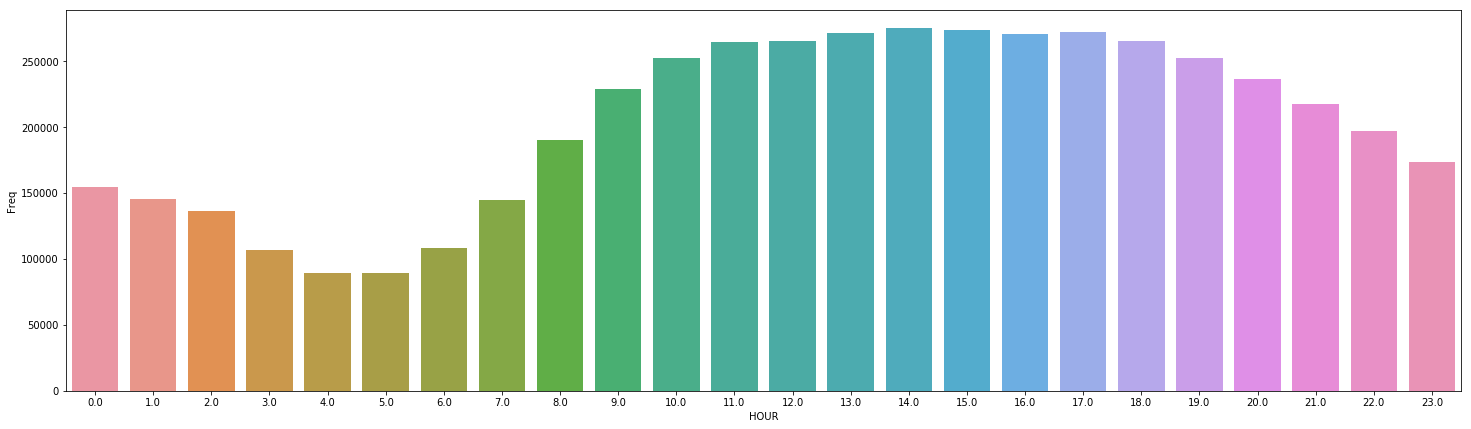

In [54]:
plt.figure(figsize=(25,7))
sns.barplot(data=ans.toPandas(), x='HOUR', y='Freq')

## Categorical Variables

For any machine learning applications, we will convert the strings to integers

Now, we convert the Call Types from Strings to Numbers

In [56]:
fireServiceCallsDF.select('CallType').limit(15).show(15, truncate=False)

+-----------------------------+
|CallType                     |
+-----------------------------+
|Medical Incident             |
|Medical Incident             |
|Medical Incident             |
|Alarms                       |
|Medical Incident             |
|Citizen Assist / Service Call|
|Electrical Hazard            |
|Odor (Strange / Unknown)     |
|Medical Incident             |
|Medical Incident             |
|Alarms                       |
|Medical Incident             |
|Medical Incident             |
|Medical Incident             |
|Alarms                       |
+-----------------------------+



### String Indexing

In [58]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexer = StringIndexer(inputCol="CallType", 
                        outputCol="CallType_Index", 
                        handleInvalid="keep",        # last index will be for invalid values not encountered before
                        stringOrderType='alphabetAsc')

new_df = indexer.fit(fireServiceCallsDF).transform(fireServiceCallsDF)

In [59]:
new_df.select("CallType", "CallType_Index").distinct().orderBy('CallType_Index').show(truncate=False)

+--------------------------------------------+--------------+
|CallType                                    |CallType_Index|
+--------------------------------------------+--------------+
|Administrative                              |0.0           |
|Aircraft Emergency                          |1.0           |
|Alarms                                      |2.0           |
|Assist Police                               |3.0           |
|Citizen Assist / Service Call               |4.0           |
|Confined Space / Structure Collapse         |5.0           |
|Electrical Hazard                           |6.0           |
|Elevator / Escalator Rescue                 |7.0           |
|Explosion                                   |8.0           |
|Extrication / Entrapped (Machinery, Vehicle)|9.0           |
|Fuel Spill                                  |10.0          |
|Gas Leak (Natural and LP Gases)             |11.0          |
|HazMat                                      |12.0          |
|High An

### One-Hot Encoding

In [60]:
encoder = OneHotEncoder(inputCol='CallType_Index', 
                        outputCol='CallType_Vec')
final_df = encoder.transform(new_df)

In [75]:
final_df

DataFrame[CallType: string, CallDate: string, WatchDate: string, ReceivedDtTm: string, EntryDtTm: string, DispatchDtTm: string, CallFinalDisposition: string, City: string, Battalion: string, StationArea: string, FinalPriority: int, ALSUnit: boolean, NumberofAlarms: int, UnitType: string, FirePreventionDistrict: string, SupervisorDistrict: string, NeighborhoodDistrict: string, Location: string, CallDateTS: date, ReceivedTS: timestamp, CallType_Index: double, CallType_Vec: vector]

The CallType_Vec is a sparse vector of length 32, it has a value of 1 at index 17 of that vector

In [63]:
final_df.select("CallType", "CallType_Index", "CallType_Vec").distinct().orderBy('CallType_Index').show(truncate=False)

+--------------------------------------------+--------------+---------------+
|CallType                                    |CallType_Index|CallType_Vec   |
+--------------------------------------------+--------------+---------------+
|Administrative                              |0.0           |(32,[0],[1.0]) |
|Aircraft Emergency                          |1.0           |(32,[1],[1.0]) |
|Alarms                                      |2.0           |(32,[2],[1.0]) |
|Assist Police                               |3.0           |(32,[3],[1.0]) |
|Citizen Assist / Service Call               |4.0           |(32,[4],[1.0]) |
|Confined Space / Structure Collapse         |5.0           |(32,[5],[1.0]) |
|Electrical Hazard                           |6.0           |(32,[6],[1.0]) |
|Elevator / Escalator Rescue                 |7.0           |(32,[7],[1.0]) |
|Explosion                                   |8.0           |(32,[8],[1.0]) |
|Extrication / Entrapped (Machinery, Vehicle)|9.0           |(32

### Applying StringIndexer and One-Hot Encoder to all categorical Variables

In [80]:
categorical_variables = [
    "CallType",
    "City",
    "NeighborhoodDistrict",
]

In [81]:
stages = []
for var in categorical_variables:
    indexer = StringIndexer(inputCol=var,
                            outputCol=var + "_Index",
                            handleInvalid="keep",
                            stringOrderType="alphabetAsc",
                            )
    encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), 
                            outputCol=var + "_classVec")
    stages += [indexer, encoder]


In [82]:
stages

[StringIndexer_74efb36f15bb,
 OneHotEncoder_a430e046a265,
 StringIndexer_077eb3f96833,
 OneHotEncoder_b45a0b37a180,
 StringIndexer_7ea1d1ea5f0c,
 OneHotEncoder_4a685b60a894]

In [83]:
from pyspark.ml import Pipeline

my_pipeline = Pipeline(stages = stages).fit(fireServiceCallsDF)
transformed_df = my_pipeline.transform(fireServiceCallsDF)

In [97]:
transformed_df.select( 'CallType', 'CallType_Index', 'CallType_classVec' ,'City', 'City_Index', 'City_classVec' ).show(15, False)

+-----------------------------+--------------+-----------------+----+----------+---------------+
|CallType                     |CallType_Index|CallType_classVec|City|City_Index|City_classVec  |
+-----------------------------+--------------+-----------------+----+----------+---------------+
|Medical Incident             |17.0          |(32,[17],[1.0])  |SF  |17.0      |(27,[17],[1.0])|
|Medical Incident             |17.0          |(32,[17],[1.0])  |SF  |17.0      |(27,[17],[1.0])|
|Medical Incident             |17.0          |(32,[17],[1.0])  |SF  |17.0      |(27,[17],[1.0])|
|Alarms                       |2.0           |(32,[2],[1.0])   |SF  |17.0      |(27,[17],[1.0])|
|Medical Incident             |17.0          |(32,[17],[1.0])  |SF  |17.0      |(27,[17],[1.0])|
|Citizen Assist / Service Call|4.0           |(32,[4],[1.0])   |SF  |17.0      |(27,[17],[1.0])|
|Electrical Hazard            |6.0           |(32,[6],[1.0])   |SF  |17.0      |(27,[17],[1.0])|
|Odor (Strange / Unknown)     

## Creating "Vectors" for ML

In Scikit-Learn or any other python library, we explicitely supply the X and y

In [ ]:
###
#Dont run
###

# scikit learn
model = LinearRegression()
model.fit(transformed_df[['CallType_Index', 'City_Index']],
          transformed_df['FinalPriority'])

But in Spark you need to assemble them beforehand using a vector assembler. Notice the **features** column has been added

In [100]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['CallType_Index', 'City_Index'],
                            outputCol = 'features')
final_df = assembler.transform(transformed_df)
final_df

stage += [assembler]
# model_fit = LinearRegression()
# model.fit(transformed_df)

DataFrame[CallType: string, CallDate: string, WatchDate: string, ReceivedDtTm: string, EntryDtTm: string, DispatchDtTm: string, CallFinalDisposition: string, City: string, Battalion: string, StationArea: string, FinalPriority: int, ALSUnit: boolean, NumberofAlarms: int, UnitType: string, FirePreventionDistrict: string, SupervisorDistrict: string, NeighborhoodDistrict: string, Location: string, CallDateTS: date, ReceivedTS: timestamp, CallType_Index: double, CallType_classVec: vector, City_Index: double, City_classVec: vector, NeighborhoodDistrict_Index: double, NeighborhoodDistrict_classVec: vector, features: vector]

In [102]:
final_df.select('CallType_Index', 'City_Index',"features").show()

+--------------+----------+-----------+
|CallType_Index|City_Index|   features|
+--------------+----------+-----------+
|          17.0|      17.0|[17.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|           2.0|      17.0| [2.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|           4.0|      17.0| [4.0,17.0]|
|           6.0|      17.0| [6.0,17.0]|
|          19.0|      17.0|[19.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|           2.0|      17.0| [2.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|           2.0|      17.0| [2.0,17.0]|
|           2.0|      17.0| [2.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|          21.0|      17.0|[21.0,17.0]|
|          17.0|      17.0|[17.0,17.0]|
|          24.0|      17.0|[24.0,17.0]|
+--------------+----------+-----------+
only showing top 20 rows



## Creating Pipelines

We will create a pipeline for all the transformations we did aboave for all the categorical and numerical variables

In [ ]:
###
#Dont run
###

stages = []

from pyspark.ml.feature import ( OneHotEncoderEstimator, StringIndexer, VectorAssembler, OneHotEncoder)
from pyspark.ml import Pipeline

# other transformations
# renaming, changing data types etc

# string Indexer
for var in categorical_variables:
    ...
    stages += [indexer, encoder]

# Vector Assembler
assembler = VectorAssembler(inputCols=["col1", "col2", "col3"], outputCol="features")
stages += [assembler]

In [106]:
stages

[StringIndexer_74efb36f15bb,
 OneHotEncoder_a430e046a265,
 StringIndexer_077eb3f96833,
 OneHotEncoder_b45a0b37a180,
 StringIndexer_7ea1d1ea5f0c,
 OneHotEncoder_4a685b60a894,
 VectorAssembler_d0f6149ee2ff]

In [109]:
# run togather
pipeline_fit = Pipeline(stages=stages).fit(fireServiceCallsDF)          # fit
transformed_fireServiceDF = pipeline_fit.transform(fireServiceCallsDF)  # transform
transformed_fireServiceDF

DataFrame[CallType: string, CallDate: string, WatchDate: string, ReceivedDtTm: string, EntryDtTm: string, DispatchDtTm: string, CallFinalDisposition: string, City: string, Battalion: string, StationArea: string, FinalPriority: int, ALSUnit: boolean, NumberofAlarms: int, UnitType: string, FirePreventionDistrict: string, SupervisorDistrict: string, NeighborhoodDistrict: string, Location: string, CallDateTS: date, ReceivedTS: timestamp, CallType_Index: double, CallType_classVec: vector, City_Index: double, City_classVec: vector, NeighborhoodDistrict_Index: double, NeighborhoodDistrict_classVec: vector, features: vector]

In [110]:
transformed_fireServiceDF.select("features", "FinalPriority").show(5)

+-----------+-------------+
|   features|FinalPriority|
+-----------+-------------+
|[17.0,17.0]|            3|
|[17.0,17.0]|            3|
|[17.0,17.0]|            3|
| [2.0,17.0]|            3|
|[17.0,17.0]|            3|
+-----------+-------------+
only showing top 5 rows



## Patitioning, Caching and Optimizations

The DataFrame is currently comprised of 14 partitions. Spark reads data in blocks of 128MB called as partitions.

In [129]:
fireServiceCallsDF.rdd.getNumPartitions()

14

In [130]:
fireServiceCallsDF.count()

4881698

![file partitions](./images/file_partitions.png)

### Remeber the number of executors we defined while creating our cluster

Notice the last 2 tasks are continuing on their own, leaving other core idle.

![executors](./images/executors.png)

## Repartition and Caching

In [131]:
fireServiceCallsDF = fireServiceCallsDF.repartition(6)
fireServiceCallsDF.cache()
fireServiceCallsDF.count() # EXECUTE the cache

In [132]:
fireServiceCallsDF.rdd.getNumPartitions()

6

The 6 partitions are now cached in memory:

![6 Partitions](http://curriculum-release.s3-website-us-west-2.amazonaws.com/sf_open_data_meetup/df_6_parts.png)

Use the Spark UI to see the 6 partitions in memory:

![Mem UI](http://curriculum-release.s3-website-us-west-2.amazonaws.com/sf_open_data_meetup/mem_ui.png)

In [133]:
fireServiceCallsDF.count()

4881698

![repart](./images/repartition.png)

## Saving to Parquet

Now that our data has the correct date types for each column and it is correctly partitioned, let's write it down as a parquet file for future loading

Wrting to parquet is expensive, but reading is dead fast

Saves a lot of space

In [134]:
fireServiceCallsDF.write.parquet("./data/my_feature_file.parquet", mode='overwrite')

In [135]:
spark.read.parquet('./data/my_feature_file.parquet').count()

4881698

### Save to Postgress

In [ ]:
fireServiceCallsDF.select('CallDateTS', 'CallType').write\
      .format("jdbc")\
      .option("driver", "org.postgresql.Driver")\
      .option("url", "jdbc:postgresql://localhost:5432/spark_demo_db")\
      .option("dbtable", "fire_service_over_time")\
      .option("user", "sahil")\
      .option("password","zxcvbnm")\
      .mode("overwrite")\
      .save()

### Save to Cassandra

You need to have created an already existing table in cassandra. Open CQLSH and execute the following commands to create a table

In [ ]:
## execute in cqlsh

CREATE KEYSPACE my_key_space WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1};
USE my_key_space ;
CREATE TABLE my_table(CallDateTS timestamp PRIMARY KEY , CallType text, IncidentNumber text PRIMARY KEY );

In [153]:
fireServiceCallsDF.select('CallDateTS', 'CallType', 'IncidentNumber').show()

+----------+----------------+--------------+
|CallDateTS|        CallType|IncidentNumber|
+----------+----------------+--------------+
|2001-02-28|Medical Incident|       1017815|
|2001-01-17|Medical Incident|       1005163|
|2001-08-09|Medical Incident|       1068465|
|2001-05-05|Medical Incident|       1038627|
|2000-12-01|          Alarms|        100347|
|2001-02-14|          Alarms|       1013594|
|2001-05-31|Medical Incident|       1046442|
|2001-09-06|Medical Incident|       1076623|
|2000-07-02|          Alarms|         55245|
|2000-12-14|Medical Incident|        104347|
|2001-06-09|    Outside Fire|       1049586|
|2001-05-24|Medical Incident|       1044282|
|2001-11-17|Medical Incident|       1098727|
|2000-06-28|Medical Incident|         53933|
|2000-07-17|Medical Incident|         59767|
|2001-05-17|  Structure Fire|       1042166|
|2001-07-28|Medical Incident|       1064646|
|2001-08-25|Medical Incident|       1073367|
|2001-04-06|Medical Incident|       1029278|
|2000-07-0

In [163]:
df = fireServiceCallsDF.select("CallDateTS", "CallType", "IncidentNumber").limit(500000)

# lower case the column names
for col in df.columns:
    df = df.withColumnRenamed(col, col.lower())

df.write.format("org.apache.spark.sql.cassandra")\
          .option("spark.cassandra.connection.host","localhost")\
          .option("spark.cassandra.connection.port","9042")\
          .option("keyspace","my_key_space")\
          .option("table","my_table2")\
          .option("confirm.truncate","true")\
          .mode("overwrite")\
          .save()